# Семинар 2. Элементы обработки сигналов / изображений. Связь между преобразованиями Фурье и преобразованиями Радона

In [1]:
import numpy as np
#import tomopy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize
import math
#from sem2utilities import radon2d, adjradon2d
from numpy.fft import fft, fftshift, ifft, ifftshift, fftn, ifftn
import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import urllib.request
import os
import pathlib
import requests

import zipfile

In [2]:
# set id (will be used later to download binary data)
my_id = 7

**Задача 2.1** Пусть PSF - гауссовский купол $PSF(x) \sim \exp(-|x|^2 / 2\sigma^2)$, $x\in R^2$. Чему равна разрешающая способность?

На практике, имея PSF, разрешающую способность системы можно определить по правилу **Рэлея**:
   * Разрешение = FWHM - full width half-maximum - ширина половины максимума PSF

Максимум в точке $x = 0$, $y = 1$

Половина максимума в $y = 0,5$.

Тогда ищем $x$, где $y = 0,5$.

$\exp(-|x|^2 / 2\sigma^2) = 0.5$

$-|x|^2 / 2\sigma^2 = ln(0.5)$

$|x|^2 = -2ln(0.5) \sigma^2$

$x = \pm \sqrt{-2ln(0.5) \sigma^2} \approx \pm 1.17741 * \sigma$

Тогда, разрешающая способность примерно равна $2.355\sigma$.

**Задача 2.2** Покажите, что преобразование $R$ на двумерной плоскости - это не LSI система. 
Рассмотрите действие $R$ на функциях с компактным носителем в квадрате $[-1,1]^2$, где образ определен в квадрате $[-1,1] \times [0, 2\pi]$.

$Rf(s,\theta) = \int\limits_{-\infty}^{+\infty} f(s\theta+ t\theta^\perp)dt, \, s \in R, \, \theta\in S^1$

Хотим проверить

* линейность - $S(\alpha f + \beta g) = \alpha S(f) + \beta S(g)$

* инвариантность относительно сдвигов - $g(x-x_0, y-y_0) = S(f_{(x_0, y_0)})(x,y), \, f_{(x_0, y_0)}(x,y) = f(x-x_0, y-y_0)$

Проверим линейность

$R(\alpha f + \beta g) = \int\limits_{-\sqrt{2-s^2}}^{\sqrt{2-s^2}} (\alpha f(s\theta+ t\theta^\perp) + \beta g(s\theta+ t\theta^\perp))dt = \alpha \int\limits_{-\sqrt{2-s^2}}^{\sqrt{2-s^2}} f(s\theta+ t\theta^\perp) dt + \beta \int\limits_{\sqrt{2-s^2}}^{\sqrt{2-s^2}} g(s\theta+ t\theta^\perp)dt = \alpha R(f) + \beta R(g) $

Проверим инвариантность относительно сдвигов

$Rf(s-s_0, \theta-\theta_0) = \int\limits_{-\sqrt{2-s^2}}^{\sqrt{2-s^2}} f((s-s_0)(\theta-\theta_0)+ t(\theta-\theta_0)^\perp)dt$

Не получилось. Вот именно из-за того, что функции с компактным носителем у нас в пределах выражение $\sqrt{2-s^2}$, поэтому все и упало.

**Задача 2.3** Докажите, что $R^*R$ - это LSI система. Найдите соотвтетствующие функции $h$, $H$ (это также могут быть обобщённые функции).

$R^*g (x) = \int\limits_{S^1}g(x\theta, \theta) d\theta$

Линейность аналогично предыдущей задаче, просто линейность по еще одному интегралу.

Инвариантность относительно сдвигов.

$R^*Rf(x-x_0) = \int\limits_{S^1} \int\limits_{R} f(((x-x_0)\theta)\theta+ t\theta^\perp) dt d\theta$

Все получилось, все правильного вида.

Найдем функции $h$, $H$.

$R^*Rf(x) = f * h(x)$

Посчитали в классе.

$R^*Rf(x) = \int\limits_{S^1} \int\limits_{R} f((x\theta)\theta+ t\theta^\perp) dt d\theta = \int\limits_{S^1} \int\limits_{\theta^{\perp}} f((x\theta)\theta+y) dy d\theta = [x = (x\theta)\theta + (x\theta^{\perp})\theta^{\perp}] = \int\limits_{S^1} d\theta \int\limits_{\theta^{\perp}} f(x + y - (x\theta^{\perp})\theta^{\perp}) dy = [z = y - (x\theta^{\perp})\theta^{\perp} \in \theta^{\perp}] = \int\limits_{S^1} d\theta \int\limits_{\theta^{\perp}} f(x + z) dz = Vol(S^0) \int\limits_{R} \frac{f(x+y)}{|y|}dy = \frac{1}{|x|} * f$

Тогда $h(x, y) = \frac{1}{\sqrt{x^2+y^2}}$.

$H(u,v) = \int\limits_{-\infty}^{+\infty}\int\limits_{-\infty}^{+\infty}h(x,y)e^{-2\pi i (ux + vy)}\, dx\,dy = \int\limits_{-\infty}^{+\infty}\int\limits_{-\infty}^{+\infty}\frac{1}{\sqrt{x^2+y^2}}e^{-2\pi i (ux + vy)}\, dx\,dy = \frac{2\pi}{\sqrt{u^2+v^2}}$

Это мы считали на курсе УМФ.





#### 2.4 Фильтры

В инженерной литературе функцию $H$ называют (спектрально-частотным) фильтром. Приведём несколько примеров:
   1. \begin{equation}
           H(u,v) = \begin{cases}
               1, \, \sqrt{u^2 + v^2} \leq \nu_{Nyq}, \\
               0,  \text{ иначе.}
                \end{cases}
      \end{equation}
   
      Этот фильтр называется *идеальным*, 
      так как он сохраняет все спектральные характеристики сигнала вплость до частоты Найквиста $\nu_{Nyq}$.
   
   2. \begin{equation}
           H(u,v) = \begin{cases}
                 \dfrac{1}{2}\left(1 + \cos(\dfrac{\pi}{2}\cdot \frac{\sqrt{u^2 + v^2}}{\nu_{Nyq}})\right),
                 \sqrt{u^2 + v^2}\leq \nu_{Nyq}, \\
                 0, \text{ иначе. }
                    \end{cases}
       \end{equation}   
       Этот фильтр называется *приподнятым косинусом* и, как видно из определения, он сохраняет низкие частоты 
       сигнала, т. к. $H(u,v) \approx 1.0$ при $(u,v) \approx (0,0)$, высокие частоты понижает в два раза 
         $H(u,v) \approx 1/2, \, \sqrt{u^2 + v^2} \approx \nu_{Nyq}$. 
         
         
   3. \begin{equation}
          H^{-}_R(u,v) = \begin{cases}
              1, \, \sqrt{u^2 + v^2} \leq R, \\
              0, \text{ иначе. }
              \end{cases}
      \end{equation}
       
      Это низкочастотный фильтр, при его применении в сигнале сохранятся детали размерами не более 
      $1/R$.
   
   4. \begin{equation}
          H^{+}_R(u,v) = \begin{cases}
              1, \, \sqrt{u^2 + v^2} > R, \\
              0, \text{ иначе. }
              \end{cases}
      \end{equation}
   
      Это высокочастотный фильтр, при его применени в сигнале сохранятся лишь детали размерами 
      менее $1 / R$. Такие фильтры например интересны для нахождения и усиления границ на изображении. 


Разберемся, как действуют вышеперечисленные фильтры на численных примерах.

**Пример.** Рассмотрим черно-белое изображение, полученное при помощи магнитно-резонансной томографии. Оно представляет собой матрицу размера $N\times N$, $N=512$. Применим к изображению два разных фильтра, высоко-частотный и низкочастотный (см. пример выше), где параметр выберем $R = \nu_{Nyq} / 8$. Cчитайте, что данное изображение соответствует квадрату $[-1,1]\times [-1,1]$. 

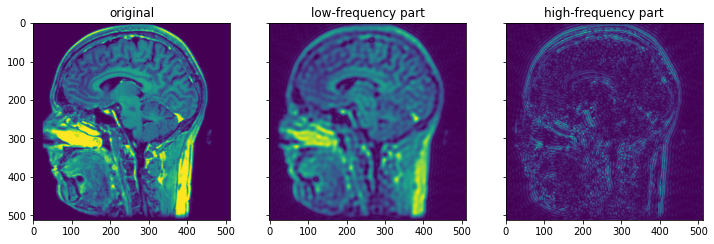

In [3]:
# Code for the examle, read the code and run the cell

# 1. read image in numpy array

filename = os.path.join(pathlib.Path().absolute(), 'mri-fourier-example.jpg')
url = 'https://drive.google.com/uc?export=download&id=1hxHGOD7uojjR8xbZo_S4dUuMtU9cLcST'
img_data = requests.get(url).content
with open(filename, 'wb') as handler:
    handler.write(img_data)


im = np.array(mpimg.imread(filename))
npixels = im.shape[0]                    # pixels per dimension (square image [-1,1] x [-1,1])
sampling_rate = npixels / 2.0
nyq = sampling_rate / 2.0                # Nyquist-frequency = half of the sampling rate
df  = sampling_rate / npixels            # frequency step

im = np.array(mpimg.imread(filename))
npixels = im.shape[0]                    # pixels per dimension (square image [-1,1] x [-1,1])
sampling_rate = npixels / 2.0
nyq = sampling_rate / 2.0                # Nyquist-frequency = half of the sampling rate
df  = sampling_rate / npixels            # frequency step

# 2. prepare low-frequency, high-frequency-filters
LF = np.zeros((npixels, npixels)) # low-frequency filter
HF = np.zeros((npixels, npixels)) # high-frequency filter

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

RF = np.sqrt(freq_factor_x**2 + freq_factor_y**2)
LF[RF < (nyq/8.0)] = 1.0 # low frequency filter
HF[RF > (nyq/8.0)] = 1.0 # high frequency filter

# 3. apply filters in Fourier domain and take inverse

LF_im = np.abs(ifftn((ifftshift(LF) * fftn(im)))) # Fourier integrals via DFT (next section)
HF_im = np.abs(ifftn((ifftshift(HF) * fftn(im))))

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
axs[0].imshow(im)
axs[0].set_title('original')
axs[1].imshow(LF_im)
axs[1].set_title('low-frequency part')
axs[2].imshow(HF_im)
axs[2].set_title('high-frequency part')
plt.show()

**Задача 2.1.** Используя код и картинку из примера выше, реализуйте идеальный фильтр и примените его. Будет ли картинка отличаться картинка от оригинала? 

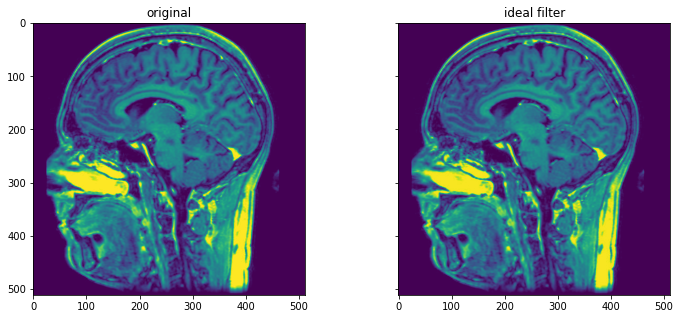

In [4]:
# Code for the examle, read the code and run the cell

# 1. read image in numpy array

filename = './mri-fourier-example.jpg'
im = np.array(mpimg.imread(filename))
npixels = im.shape[0]                    # pixels per dimension (square image [-1,1] x [-1,1])
sampling_rate = npixels / 2.0
nyq = sampling_rate / 2.0                # Nyquist-frequency = half of the sampling rate
df  = sampling_rate / npixels            # frequency step

# 2. prepare filter
IF = np.zeros((npixels, npixels))

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

RF = np.sqrt(freq_factor_x**2 + freq_factor_y**2)
IF[RF < (nyq)] = 1.0 

# 3. apply filters in Fourier domain and take inverse

IF_im = np.abs(ifftn((ifftshift(IF) * fftn(im)))) # Fourier integrals via DFT (next section)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(im)
axs[0].set_title('original')
axs[1].imshow(IF_im)
axs[1].set_title('ideal filter')
plt.show()

**Ответы на вопросы из задачи 2.1:** 



Фильтр очень хороший, идеальный. Видно, что отличий почти нет. Отличия в изображениях проявляются только на границах и в очень ярких местах изображения. Скорее всего происходит небольшое сглаживание, но возможно это связано с машинной точностью.

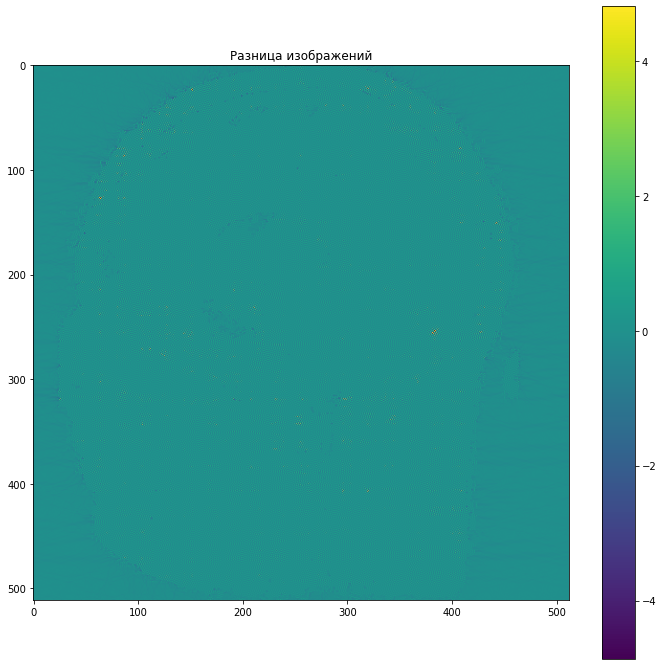

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(im - IF_im)
axs.set_title('Разница изображений')
fig.colorbar(im, ax=axs)
plt.show()

**Задача 2.2.** Используя код из примера, реализуйте фильтр "приподнятый косинус" и проверье его на изображении из примера.

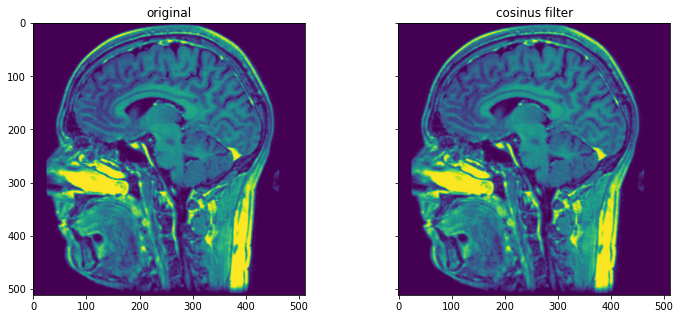

In [6]:
# Code for the examle, read the code and run the cell

# 1. read image in numpy array

filename = './mri-fourier-example.jpg'
im = np.array(mpimg.imread(filename))
npixels = im.shape[0]                    # pixels per dimension (square image [-1,1] x [-1,1])
sampling_rate = npixels / 2.0
nyq = sampling_rate / 2.0                # Nyquist-frequency = half of the sampling rate
df  = sampling_rate / npixels            # frequency step

# 2. prepare filter
CF = np.zeros((npixels, npixels))

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

RF = np.sqrt(freq_factor_x**2 + freq_factor_y**2)
for i in range(npixels):
    for j in range(npixels):
        if (RF[i][j] <= nyq):
            CF[i][j] = 0.5 * (1 + np.cos(np.pi * RF[i][j] / nyq / 2))

# 3. apply filters in Fourier domain and take inverse

CF_im = np.abs(ifftn((ifftshift(CF) * fftn(im)))) # Fourier integrals via DFT (next section)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(im)
axs[0].set_title('original')
axs[1].imshow(CF_im)
axs[1].set_title('cosinus filter')
plt.show()

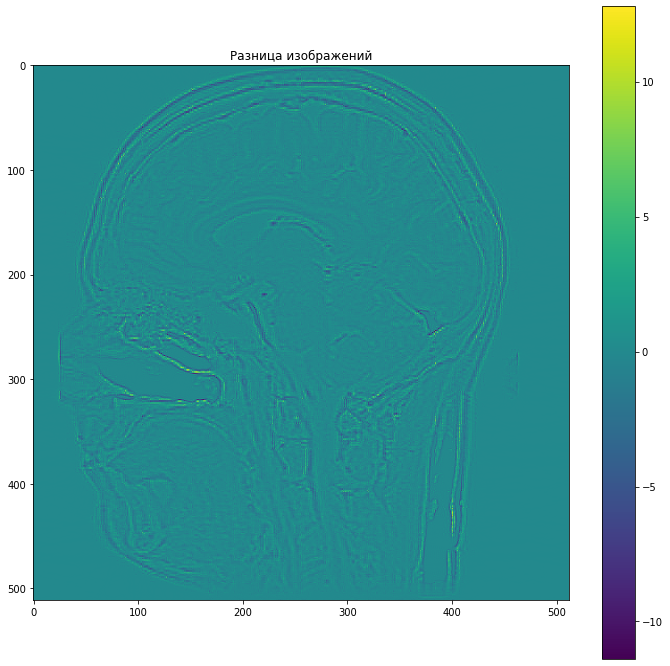

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(CF_im - im)
axs.set_title('Разница изображений')
fig.colorbar(im, ax=axs)
plt.show()

**Задание 2.3.** Постройте изображение PSF для идеального фильтра и для приподнятого конуса.

Так как $PSF$ это $h$, $H = Fh$, то $PSF$ это обратное преобразование Фурье от $H$.

PSF идеального фильтра, то есть функция $h$. Теперь понятно, почему POINT spread function.

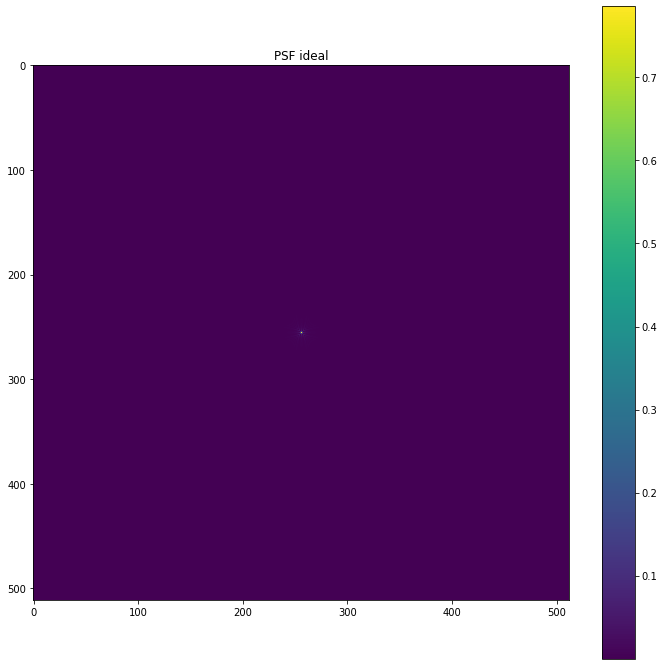

In [8]:
PSFI = fftshift(ifftn(ifftshift(IF)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(PSFI))
axs.set_title('PSF ideal')
fig.colorbar(im, ax=axs)
plt.show()

Сам идеальный фильтр, то есть функция $H$, восстановленная как преобразование Фурье от вычисленного $h$. 

Это просто проверка, что все получилось. Видно, что полученная функция ведет себя именно так, как описано в условии задания. Значит, все получилось.

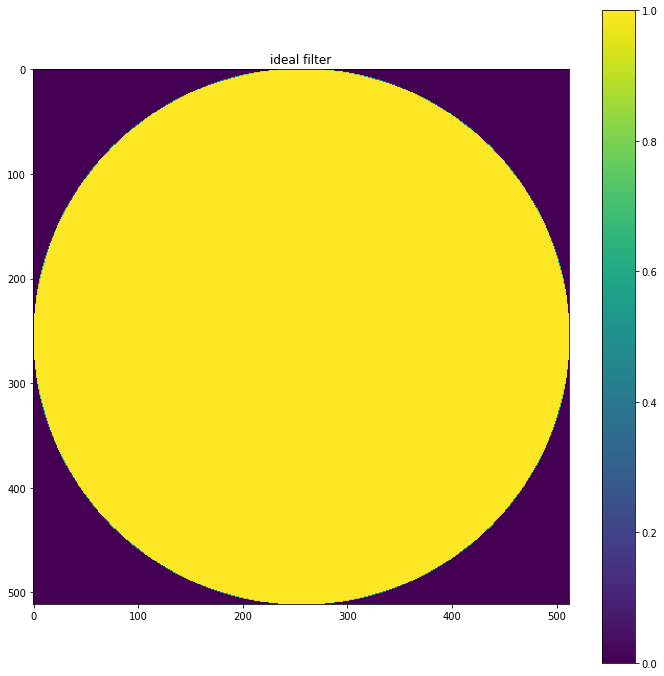

In [9]:
I = fftshift(fftn(ifftshift(PSFI)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(I))
axs.set_title('ideal filter')
fig.colorbar(im, ax=axs)
plt.show()

Аналогично дальше будет всего по 2, заодно я увижу и сами фильтры.

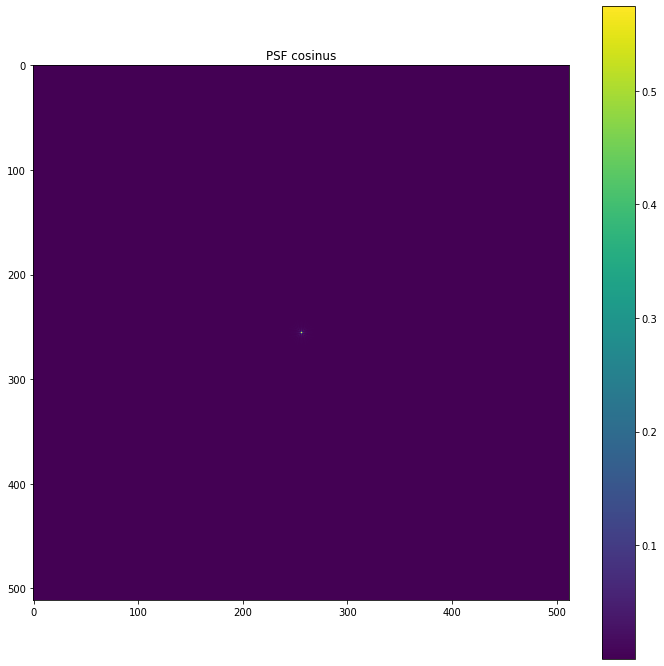

In [10]:
PSFC = fftshift(ifftn(ifftshift(CF)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(PSFC))
axs.set_title('PSF cosinus')
fig.colorbar(im, ax=axs)
plt.show()

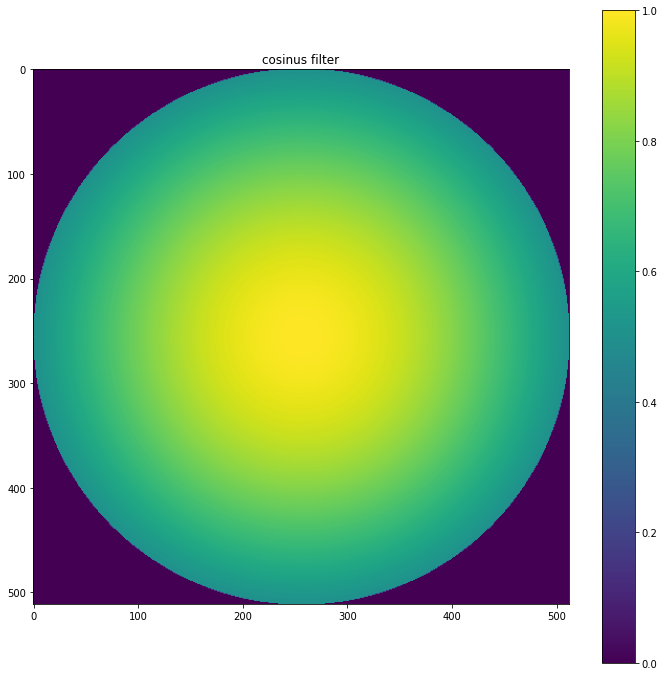

In [11]:
C = fftshift(fftn(ifftshift(PSFC)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(C))
axs.set_title('cosinus filter')
fig.colorbar(im, ax=axs)
plt.show()

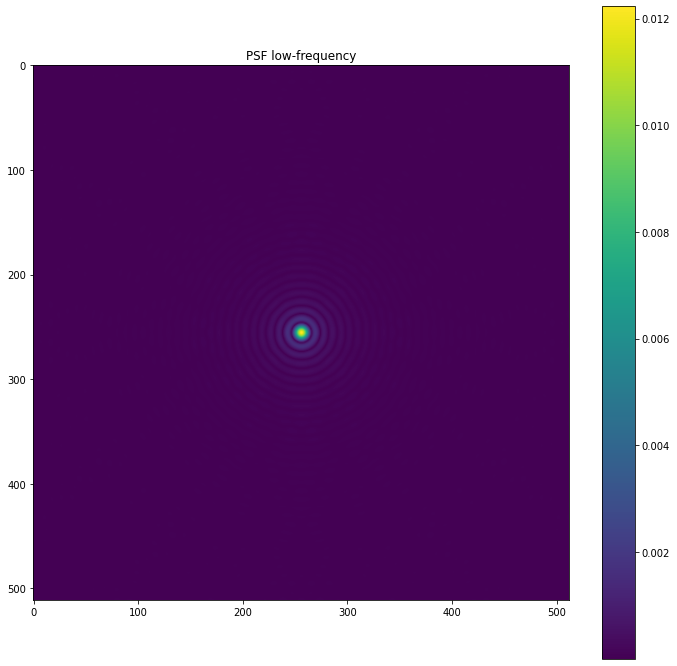

In [12]:
PSFL = fftshift(ifftn(ifftshift(LF)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(PSFL))
axs.set_title('PSF low-frequency')
fig.colorbar(im, ax=axs)
plt.show()

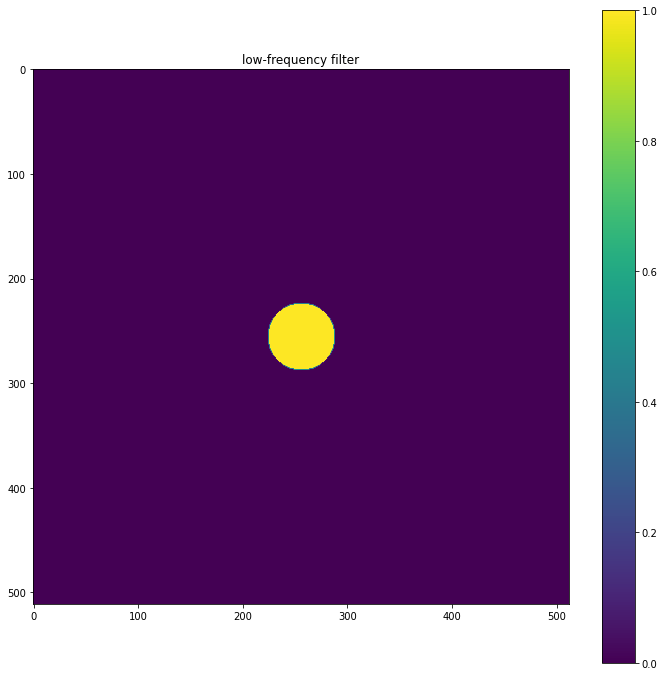

In [13]:
L = fftshift(fftn(ifftshift(PSFL)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(L))
axs.set_title('low-frequency filter')
fig.colorbar(im, ax=axs)
plt.show()

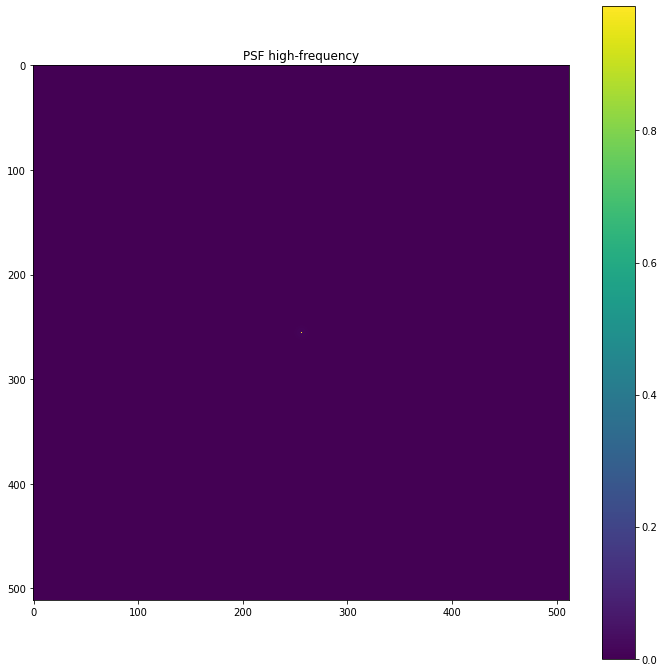

In [14]:
PSFH = fftshift(ifftn(ifftshift(HF)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(PSFH))
axs.set_title('PSF high-frequency')
fig.colorbar(im, ax=axs)
plt.show()

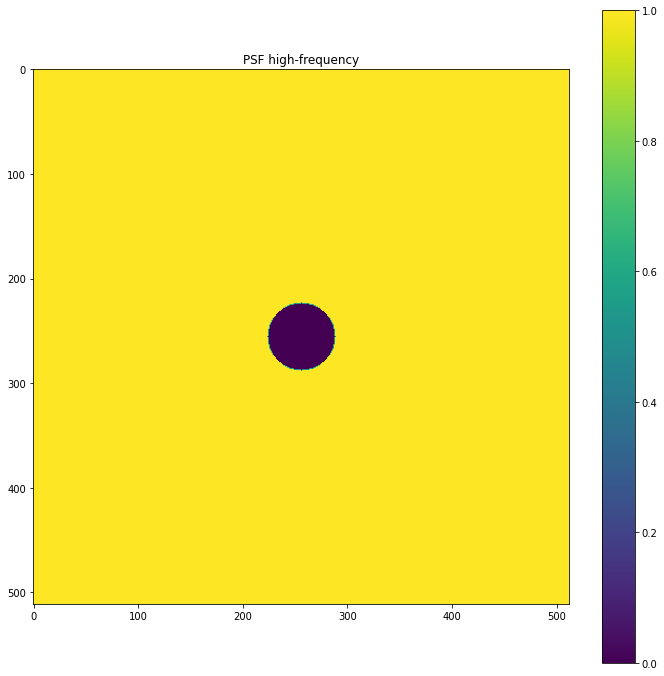

In [15]:
H = fftshift(fftn(ifftshift(PSFH)))
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(H))
axs.set_title('PSF high-frequency')
fig.colorbar(im, ax=axs)
plt.show()

**Задача 2.3.* (факультативно)** Попробуйте придумать фильтр, который будет не только сохранять границы изображения, но и "усиливать" их (низкочастотную часть изображения можно "убрать" - лишь бы границы было лучше видно). Объясните ниже словами, как вы строите данный фильтр и почему вы считаете, что он будет усиливать границы. 

Границы - место, где сильнее всего меняется градиент функции. 

$smooth image = c \cdot image$

Хотим построить какую-то функцию $c = g(||\nabla image||)$ так, чтобы на границе не было размытия, а в области было. Чем больше норма градиента, тем четче граница.

Выберем как функцию $g = 1 - e^{-(\frac{x}{k})^2}$

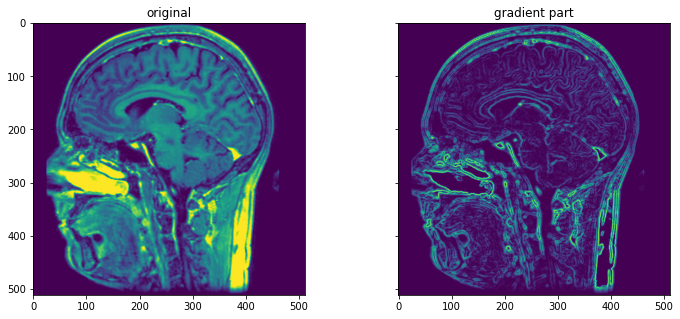

In [16]:
filename = './mri-fourier-example.jpg'
im = np.array(mpimg.imread(filename))
npixels = im.shape[0]                    # pixels per dimension (square image [-1,1] x [-1,1])
sampling_rate = npixels / 2.0
nyq = sampling_rate / 2.0                # Nyquist-frequency = half of the sampling rate
df  = sampling_rate / npixels            # frequency step

im = np.array(mpimg.imread(filename))
npixels = im.shape[0]                    # pixels per dimension (square image [-1,1] x [-1,1])
sampling_rate = npixels / 2.0
nyq = sampling_rate / 2.0                # Nyquist-frequency = half of the sampling rate
df  = sampling_rate / npixels            # frequency step

GF = np.zeros((npixels, npixels)) # high-frequency filter

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

grad1, grad2 = np.gradient(im)
k = 16

for i in range(npixels):
    for j in range(npixels):
        GF[i][j] = 1 - np.exp(-(grad1[i][j]**2+grad2[i][j]**2)/k**2)

# 3. apply filters in Fourier domain and take inverse

GF_im = np.abs(GF * im)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(im)
axs[0].set_title('original')
axs[1].imshow(GF_im)
axs[1].set_title('gradient part')
plt.show()

**Задание 2.1.** Вычислите численно преобразование Фурье от функции $g(x,y) = 1 / (x^2 + y^2 + 1)^{3/2}$. Сравните результат с аналитическим результатом, посчитав его заранее. 

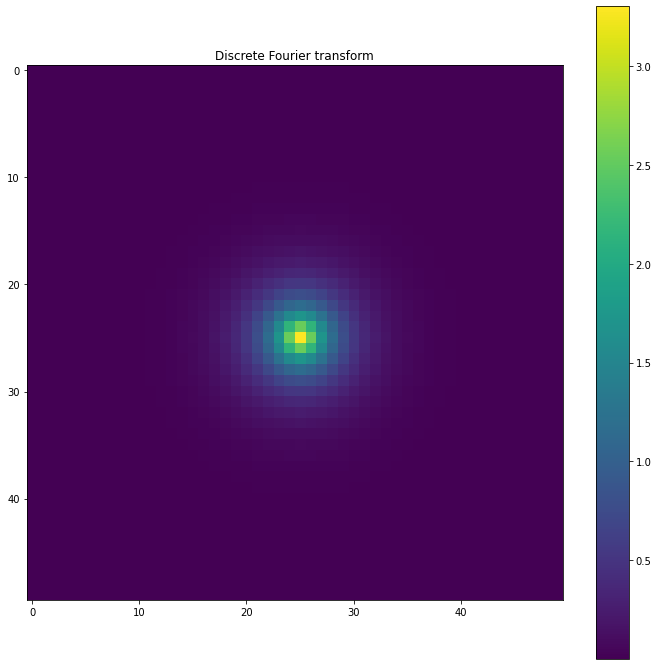

In [17]:
# parameters of the domain

nx = 2**8
ny = nx
xmax = 2**3
dx = 2*xmax / nx
dy = dx

# create g(x,y)
x = np.linspace(-nx/2, nx/2-1) * dx
y = np.linspace(-ny/2, ny/2-1) * dy
xx,yy = np.meshgrid(x, y)
gxy = 1. / (xx**2 + yy**2 + 1)**(1.5)

G = dx * fftshift(fftn(ifftshift(gxy)))

fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(G))
axs.set_title('Discrete Fourier transform')
fig.colorbar(im, ax=axs)
plt.show()


## 3. Обращение преобразований Радона при помощи преобразования Фурье и алгоритма обратной проекции

pip install numbaВ данном параграфе мы займемся реализацией формулы обратной проекции (формулу обращения Радона) через обратное преобразования Фурье при помощи DFT.

Напомним формулу обращения, полученную во введении:

\begin{equation}
    f(x) = \int\limits_{S^1}d\theta \int\limits_{-\infty}^{+\infty} \dfrac{|\rho|}{2}\widehat{Rf}(\rho, \theta)
    e^{2\pi i\rho(x,\theta)}\, d\rho, \, x\in R^2.
\end{equation}

Данную формулу можно приблизить следующей конечной суммой:

\begin{equation}
    f(x) \approx \Delta_\theta \Delta_\rho\sum_{i=1}^{N_\theta} \sum_{j = 1}^{N_\rho} \dfrac{|\rho_j|}{2}
    \widehat{Rf}(\rho_j, \theta_i) e^{2\pi i (x,\theta_i)\rho_j}, 
\end{equation}

где $\widehat{Rf}(\rho_j,\theta_i)$ - одномерное преобразование Фурье от $Rf$, $\Delta_\rho, \Delta_\theta, N_\rho, N_\theta$ - параметры лучевых данных.

Таким образом псевдо-алгоритм обращения $R$ при помощи формулы обратной проекции следующий:

    # BEGIN 
        
        # initilializittion
        0. Delta_phi, Delta_shift, N_shift, N_theta
        1. initialize arrays: shift[i], theta[j], rho[j]
        2. initialize domain array : x[k] 
           values of the function  : f[k]
        3. padding_length
        
        # compute Rf^(rho_j, theta_i) via 1D Fourier transforms via DFT 
        
        for all i do : 
            Rf(s, theta_i) <- padd with zeros on both sides along s-axis
            Rf^(rho_j, theta_i) = fftshift(fft(ifftshift(Rf(* , theta_i))))
        endfor
        
        # compute values of f[k] at x[k] via approximation of FBP
        
        for x in x[k] do : 
            f[k] = Delta_rho Delta_phi * sum_i sum_j (rho_j / 2) * Rf^(rho_j, theta_i) exp(2pi * 1i * rho_j \ 
                                                                                       * (x[k],theta_i))
        endfor
        
        return f
        
    # END

**Задание 3.1.** Реализуйте формулу обратной проекции, используя формулу выше и соответствующий псевдокод алгоритма.

In [73]:
def radon2d_fbp(npixels, projections, radius, padding):
    ntheta = len(projections)
    nshift = len(projections[0])
    deltatheta = 2 * np.pi / ntheta
    deltashifts = 2 / nshift

    shifts = np.linspace(-radius + deltashifts/2, radius - deltashifts/2, nshift)
    theta = np.linspace(-np.pi, np.pi, ntheta, endpoint = False)
    x = np.linspace(-radius, radius, npixels)
    f = np.zeros((npixels, npixels))


    Rf = projections
    RRf = []

    tic1 = time.perf_counter()

    for i in range(ntheta):
        RRf.append(np.pad(Rf[i], (padding, padding), 'constant', constant_values=(0, 0)))

    toc1 = time.perf_counter()
    elapsed_time1 = toc1 - tic1 # in seconds
    
    nrho = len(RRf[0])
    N = nrho * deltashifts / 2 
    rho = np.linspace(-N, N, nrho)

    RFF = []

    tic2 = time.perf_counter()

    for i in range(ntheta):
        RFF.append(fftshift(fft(ifftshift(RRf[i]))))
    

    toc2 = time.perf_counter()
    elapsed_time2 = toc2 - tic2 # in seconds

    tic3 = time.perf_counter()

    delta = deltashifts * deltatheta
    v = 2 * np.pi * 1j

    def eps(a, axis=0, keepdims=True):
        return np.apply_along_axis(np.exp, axis, a)

    for i in range(npixels): 
        for j in range(npixels):
            xtheta = v * (x[j] * np.apply_along_axis(np.cos, 0, theta) + x[i]*np.apply_along_axis(np.sin, 0, theta))
            fin = np.outer(xtheta, rho)
            rhoe = np.apply_over_axes(eps, fin, 0)
            res = np.multiply(rhoe, np.apply_along_axis(np.abs, 0, rho)/2)
            f[i][j] = np.sum(np.multiply(RFF, res)) * delta
    
    
    toc3 = time.perf_counter()
    elapsed_time3 = toc3 - tic3 # in seconds

    return f, elapsed_time1, elapsed_time2, elapsed_time3

**Задание 3.2.** Протестируйте ваш алгоритм восстановления на двух фантомах из прошлого задания. То есть вычислите  преобразования Радона используя функцию `radon2d(image, ntheta, nshift, radius=1.0)` из прошлого задания и примените формулу обратной проекции. В качестве параметров, возьмите разрешение изображений $64\times 64$, $N_s=256$, $N_\theta=512$. (Если восстановление выглядит неудовлетворительно, попробуйте увеличить количество лучевых данных) Проделайте восстановления для совсем небольших значений $N_s$ и $N_\theta$ и опишите какие артефакты вы видите?
Как это связано с теоремой Найквиста-Шеннона-Котельникова? При каких значениях $N_s$ и $N_\theta$ артефакты практически отсутствуют? (поэкспериментируйте с некоторым набором значений)


**Ссылка**: Правило выбора $N_s$ и $N_\theta$ можно найти в книжках: Natter - Mathematics of Computerized Tomography, 
и в Thorsten M. Buzug, Computed Tomography From Photon Statistics to Modern Cone-Beam CT. В целом, 
обычно выбирают: 

\begin{equation}
    N_s = 2N , N_\theta = \pi N,
\end{equation}
где $N$ - количество пикселей вдоль одной стороны изображения.

Какая часть вашего алгоритма работает дольше всего? Для вычисления времени выполнения части кода используйте функцию `perf_counter()` из модуля `time`:

        tic = time.perf_counter()
        ....
        toc = time.perf_counter()
        elapsed_time = toc - tic # in seconds


Выбор паддинга.

$\Delta_s \Delta_{\theta} = \frac{2}{N_s} \frac{2\pi}{N_{\theta}} = \frac{1}{L}$

$L = 2 \cdot padding + N_s$

$2 \cdot padding + N_s = \frac{N_s N_{\theta}}{4 \pi} $

$padding = \frac{N_s}{2} \cdot  (\frac{N_\theta}{4\pi} - 1)$

$N_s = 2N , \quad N_\theta = \pi N$

$padding = N \cdot (\frac{N}{4} - 1)$

Но по идее чем больше взять паддинг, тем лучше.

In [19]:
filename = os.path.join(pathlib.Path().absolute(), 'sem2utilities.zip')
url = 'https://drive.google.com/uc?export=download&id=1IgCvmd2W0IDbwlCzO6ngDIeE8t0ZZtgb'
img_data = requests.get(url).content
with open(filename, 'wb') as handler:
    handler.write(img_data)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(pathlib.Path()))

from sem2utilities import radon2d, adjradon2d

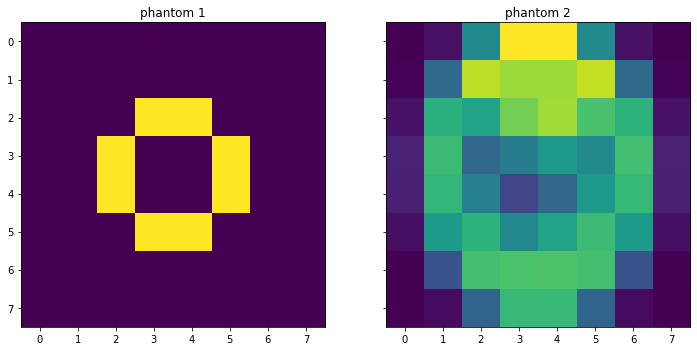

In [20]:
def circ_phantom(N):
    lin = np.linspace(-1,1, N)
    [XX, YY] = np.meshgrid(lin, lin)
    RR = np.sqrt(XX**2 + YY**2)
    circ_image = np.zeros((N,N))
    circ_image[RR < 0.5] = 1.
    circ_image[RR < 0.25] = 0.
    
    return circ_image

# 1. phantoms 

N = 8
phantom1 = circ_phantom(N) # circular layer Phantom
phantom2 = resize(shepp_logan_phantom(), (N, N),
                       anti_aliasing=True) # Shepp-Logan Phantom

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
axs[0].imshow(phantom1)
axs[0].set_title('phantom 1')
axs[1].imshow(phantom2)
axs[1].set_title('phantom 2')
plt.show()

# 2. computation of projection data

projection1 = radon2d(phantom1, 25, 16)
projection2 = radon2d(phantom2, 25, 16)

Для небольших $N_s$ и $N_{\theta}$.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


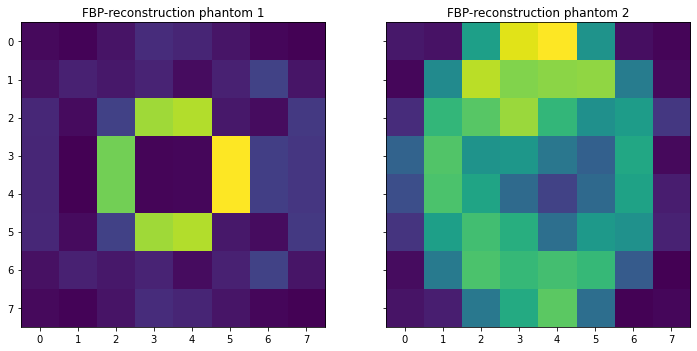

Padding time for phantom 1 :  0.0016721799984225072
Fourie time for phantom 1 :  0.0030295489996206015
Inverse fourie time for phantom 1 :  0.041706228999828454
Padding time for phantom 2 :  0.0006888290008646436
Fourie time for phantom 2 :  0.0008831990053295158
Inverse fourie time for phantom 2 :  0.03083736400003545


In [21]:
padding = 20

reconstruction1_8, time11, time12, time13 = radon2d_fbp(8, projection1, 1.0, padding)
reconstruction2_8, time21, time22, time23 = radon2d_fbp(8, projection2, 1.0, padding)

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
axs[0].imshow(np.abs(reconstruction1_8))
axs[0].set_title('FBP-reconstruction phantom 1')
axs[1].imshow(np.abs(reconstruction2_8))
axs[1].set_title('FBP-reconstruction phantom 2')
plt.show()

print('Padding time for phantom 1 : ', time11)
print('Fourie time for phantom 1 : ', time12)
print('Inverse fourie time for phantom 1 : ', time13)

print('Padding time for phantom 2 : ', time21)
print('Fourie time for phantom 2 : ', time22)
print('Inverse fourie time for phantom 2 : ', time23)

Есть артефакты по краям. 

Теорема Найквиста—Шеннона—Котельникова гласит, что восстановить без искажений можно только сигнал, спектр которого ограничен некоторой частотой (частота Найквиста). Тут спектр неограничен, нет конечной ширины пропускания. В результате точное восстановление сигнала невозможно.

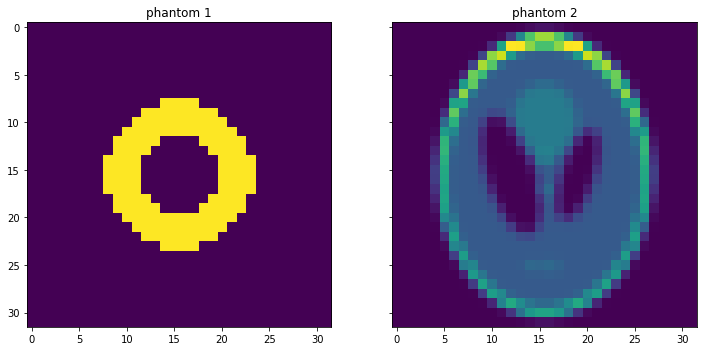

In [22]:
def circ_phantom(N):
    lin = np.linspace(-1,1, N)
    [XX, YY] = np.meshgrid(lin, lin)
    RR = np.sqrt(XX**2 + YY**2)
    circ_image = np.zeros((N,N))
    circ_image[RR < 0.5] = 1.
    circ_image[RR < 0.25] = 0.
    
    return circ_image

# 1. phantoms 

N = 32
phantom1_32 = circ_phantom(N) # circular layer Phantom
phantom2_32 = resize(shepp_logan_phantom(), (N, N),
                       anti_aliasing=True) # Shepp-Logan Phantom

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
axs[0].imshow(phantom1_32)
axs[0].set_title('phantom 1')
axs[1].imshow(phantom2_32)
axs[1].set_title('phantom 2')
plt.show()

# 2. computation of projection data

projection1_32 = radon2d(phantom1_32, 100, 64)
projection2_32 = radon2d(phantom2_32, 100, 64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


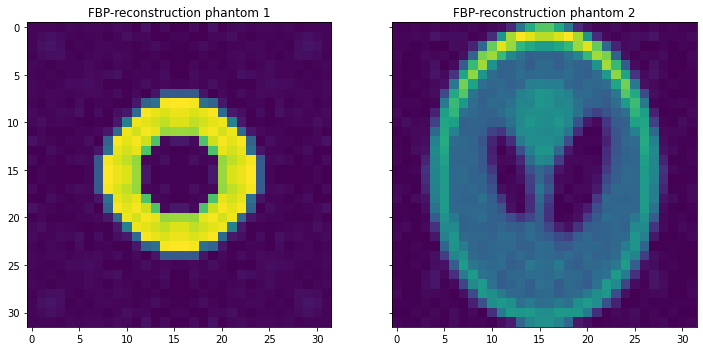

Padding time for phantom 1 :  0.005477820996020455
Fourie time for phantom 1 :  0.008897187995899003
Inverse fourie time for phantom 1 :  21.787296492002497
Padding time for phantom 2 :  0.0028668119994108565
Fourie time for phantom 2 :  0.004985146995750256
Inverse fourie time for phantom 2 :  16.664489396993304


In [23]:
reconstruction1_32, time11, time12, time13 = radon2d_fbp(32, projection1_32, 1.0, 448)
reconstruction2_32, time21, time22, time23 = radon2d_fbp(32, projection2_32, 1.0, 448)

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
axs[0].imshow(np.abs(reconstruction1_32))
axs[0].set_title('FBP-reconstruction phantom 1')
axs[1].imshow(np.abs(reconstruction2_32))
axs[1].set_title('FBP-reconstruction phantom 2')
plt.show()

print('Padding time for phantom 1 : ', time11)
print('Fourie time for phantom 1 : ', time12)
print('Inverse fourie time for phantom 1 : ', time13)

print('Padding time for phantom 2 : ', time21)
print('Fourie time for phantom 2 : ', time22)
print('Inverse fourie time for phantom 2 : ', time23)

**Ответы на вопросы из Задания 3.2.:** 

Дольше всего выполняется подсчет интеграла через суммы. Асимптотика этой операции $O(N_{pixels}^2 \times N_s \times N_\theta)$, поэтому так долго. Это так, потому что сетка, по которой ведется суммирование, неравномерная в пространстве частот.

То есть первые 2 шага, то есть padding и 1D Фурье построчно это довольно быстрая история, а суммирование заняло много времени.

**Задание 3.3.** Восстановите изображение из лучевых данных из binary-файла, который подготовлен заранее. Выполните строку ниже, которая загрузит лучевые данные в вашу текущую папку и примените к данным алгоритм обратной проекции тем самым восстановите изображение. 

Формат файла: 

    binary file N_theta = 512, N_s=256, floats of 4 bytes each, binary format - little endian 
    
Бинарные файлы в NumPy можно загружать при помощи команды:

    np.fromfile(file, dtype=float, count=-1, sep=",", offset=0)
    

In [24]:
# library for file download

!pip install wget
import wget

filename = os.path.join(pathlib.Path().absolute(), 'imag' + str(my_id) + '.bin')
#os.remove(filename)

url = 'https://raw.github.com/fedor-goncharov/pdo-tomography-course/master/seminar-materials/seminar-2/' + 'imag' + str(my_id) + '.bin'
output_path = './'
wget.download(url, output_path)


'.//imag7 (1).bin'

In [25]:
# read projections from the downloaded binary file

ntheta = 512
nshift = 256

projections_exterior_data = np.reshape(np.fromfile(filename, dtype=np.float), (ntheta, nshift))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


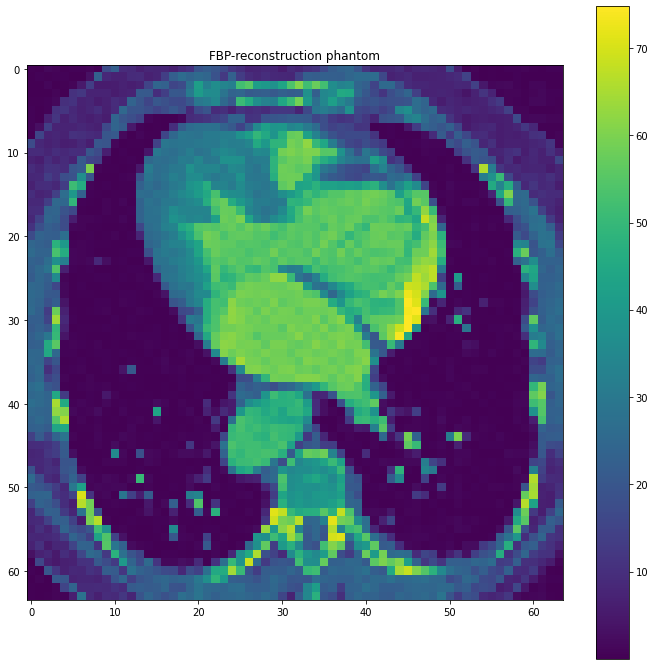

Padding time for binary data :  0.041554031005944125
Fourie time for binary data :  0.12718238399975235
Inverse fourie time for binary data :  1633.7749836290022


In [27]:
reconstruction, time1, time2, time3 = radon2d_fbp(64, projections_exterior_data, 2.0, 3000)

fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(reconstruction))
axs.set_title('FBP-reconstruction phantom')
fig.colorbar(im, ax=axs)
plt.show()

print('Padding time for binary data : ', time1)
print('Fourie time for binary data : ', time2)
print('Inverse fourie time for binary data : ', time3)

### 4.1 Спектральная реализация формулы обратной проекции  

Формулу FBP можно реализовать множеством различных способов - все они в итоге должны давать одинаковые восстановления, но могут существенно различатся по скорости вычислений и по требованиям к памяти. 

В параграфе 3 при реализации FBP мы использовали следующий порядок вычислений: 

 1. Вычисление $\widehat{Rf}$ (очень быстро)
 2. Применение фильтра $\sim |\rho|$ (очень быстро)
 3. Обратное проецирование данных - вычисление суммы интеграла Фурье (медленно)

Но можно провести восстановления и в обратном порядке (обратная проекция, потом фильтрация):

 1. Вычисление обратной проекции $R^*Rf$ (возможно не быстро)
 2. Применение спектрального фильтра $\sim |\rho|$ (быстро, так как можно реализовать через DFT)
 3. Обратное проецирование данных - вычисление суммы интеграла Фурье (быстро, так как на равномерной сетке, DFT)
 
**Замечание:** не всегда можно менять местами проецирование и фильтрацию, но в данном случае, на плоскости $R^2$ это действительно приводит к тому-же результату.
 
**Задание в этом параграфе:** В данной главе мы займемся последней реализацией FBP и сравним скорость нового алгоритма с алгоритмом  из задания 3. Главный ключ к нашей реализации - это следующая формула: 
\begin{equation}
    R^*Rf(x) = 2 \left(f \ast \dfrac{1}{|x|}\right)(x),
\end{equation}
где $R^*$ - формула обратной проекции, $R$ - преобразование Радона, $\ast$ - обозначает конволюцию функций на $R^2$.

**Упражнение (факультативно).** Докажите корректность данной формулы.

Несложно показать, что с точки зрения преобразования Фурье предыдущая формула выглядит следующим образом: 
\begin{equation}
    F(R^*Rf)(\xi) = Ff(\xi) \cdot \dfrac{1}{|\xi|}, \, \xi \neq 0.
\end{equation}
 
Тогда мы сразу получаем следующий алгоритм для FBP:

    
         # 1. initialization
             image(x,y) = []
             filter(xi_1,xi_2) = |(xi_1, xi_2)|
             projection-data(ntheta, nshift)
         # 2. Compute adjoint from projection data
             g(x,y) = R*(projection-data)(x,y)
         # 3. Take Fourier transform of g
             Fg(xi_1, xi_2) = 
         # 4. Apply filter
             WFg(xi_1, xi_2) = Fg(xi_1, xi_2) .* filter(xi_1, xi_2) # elementwise product
         # 5. Take inverse Fourier transform
             image(x,y) = F^{-1}(WFg)(x,y)
       
             return image
       
    
**Задание 4.1** Имплементируйте псевдокод выше для восстановления сигнала по лучевым преобразованиям. В качестве оператора $R^*$ используйте функцию `adjradon2d(...)` имплементированную ниже (этот код работает намного быстрее того, что вы писали в первом задании, так как он не вычисляет матрицу для $R$). Для применения фильтра в пространстве частот можете использовать участки кода для реализации FBP из главы 3. Примените реализованный метод восстановления к лучевым данным из задания 3.2.



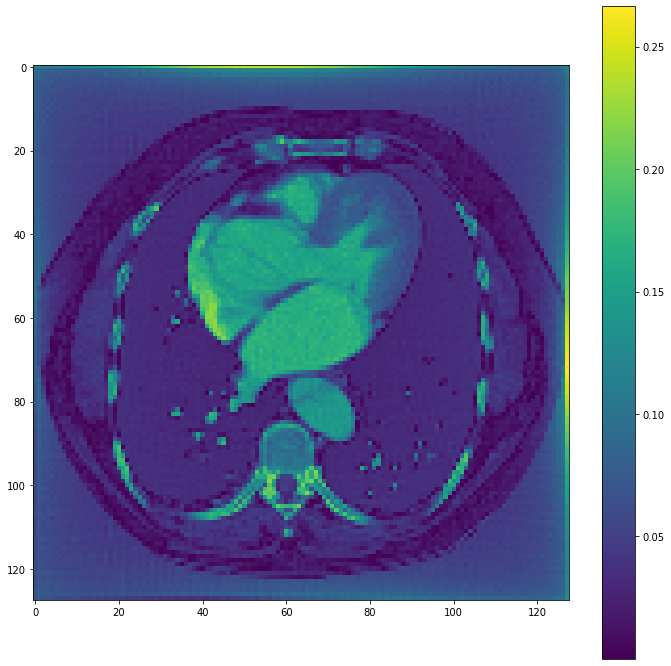

In [86]:
tic = time.perf_counter()

# 1. compute adjoint

npixels = 128
dom_rad = 1.0
adjoint_exterior_data = adjradon2d(projections_exterior_data, npixels, dom_rad)

image = np.zeros((npixels, npixels))

# 2. create Fourier filter

filter = np.zeros((npixels, npixels))

sampling_rate = npixels / 64.0            
df  = sampling_rate / npixels            # frequency step

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

filter = np.sqrt(freq_factor_x**2 + freq_factor_y**2)

# 3. apply Fourier filter

image = np.abs(ifftn(ifftshift(filter) * fftn(adjoint_exterior_data)))

toc = time.perf_counter()
elapsed_time = toc - tic # in seconds

fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(image)
axs.set_title('')
fig.colorbar(im, ax=axs)
plt.show()


**Задание 4.2** Сравните скорость работы нового алгоритма, с алгоритмом из задания 3.2. Для вычисления времени выполнения части кода используйте функцию `perf_counter()` из модуля `time`. Существенным ли получилось ускорение?

In [60]:
print('time', elapsed_time, 'seconds')

time 0.2370493609996629 seconds


Код выполняется значительно быстрее. А учитывая то, что до применения матричный алгебры код из задания 3.3 выполнялся ltym, ускорение просто колоссально большое. То есть метод наивного сложения точно очень долгий.

**Замечение:** при правильном восстановлении, значения на краю изображения (например, в диапазоне [0:10, 0:10]) должны быть равны $0$ ну или близки к ним. Выполняется ли это свойство в вашем случае? Как вы можете объяснить результат в вашем случае?



Там не нули. Это связано с появлением артефактов из-за того, что функция $R^*Rf$ не имеет ограниченного носителя.

**Задание 4.3.** По краям восстановленного изображения можно заметить артефакты, этому есть простое объяснение. Функция $R^*Rf$ в $R^2$ не имеет компактного носителя, так как это конволюция с функцией $1/ |x|$ с неограниченным носителем . Мы используем значения $R^*Rf$ в квадрате $N\times N$ пикселей, поэтому при использовании DFT, где неявно предполагается, что картинка - это периодический сигнал, мы получаем "разрывы" гладкости по границам изображения (в этих участках функция недифференцируема). Фильтр $\sim |\rho|$ соответствует производной (на самом деле производной от преобразования Гильберта), поэтому на границах мы получаем артефакты в виде скачков. В этом задании вам предлагается использовать "трюк", чтобы уменьшить влияние этих артефактов. Для этого, сначала восстановите $R^*Rf$ на большей картинке (например, $2N\times 2N$ пикселей), после чего домножьте (попиксельно) изображение на функцию, которая равна $1.0$ в круге вписанном в квадрат $N\times N$ пикселей и гладко убывает к нулю к краям квадрата $2N\times 2N$ (такая функция называется маской). После этого примените фильтр $\sim |\rho|$, в квадрате $N\times N$ будет находится нужное вам изображение. Идея в том, что использование маски позволяет сделать сигнал "периодичным" без разрывов, что уберёт артефакты по краям после применения фильтра. Реализуйте описанный алгоритм и проверьте его на данных из задания 3.3. (для создания маски полезной может оказаться функция [Smoothstep](https://en.wikipedia.org/wiki/Smoothstep))

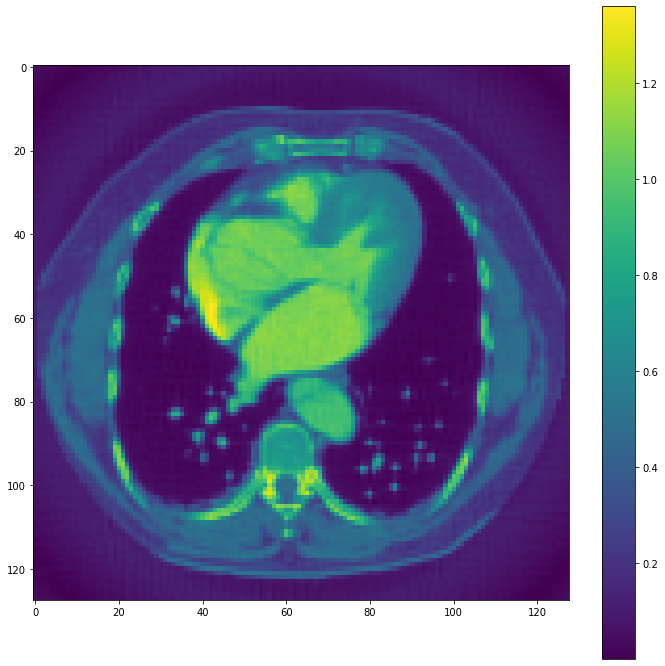

In [85]:
# 1. compute adjoint
npixels = 256
dom_rad = 2.0
adjoint_exterior_data = adjradon2d(projections_exterior_data, npixels, dom_rad)

image = np.zeros((npixels, npixels))

# 2. create Fourier filter

filter = np.zeros((npixels, npixels))

sampling_rate = npixels / 64.0            
df  = sampling_rate / npixels            # frequency step

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

filter = np.sqrt(freq_factor_x**2 + freq_factor_y**2)

# 3. apply Fourier filter

image = np.abs(ifftn(fftn(adjoint_exterior_data) * filter))


SF = np.zeros((npixels, npixels))

freq_array = fftshift(range(npixels)).astype(np.float)
freq_array[freq_array >= (npixels / 2)] -= npixels
freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
freq_factor_x *= df
freq_factor_y *= df

RF = np.sqrt(freq_factor_x**2 + freq_factor_y**2)
for i in range(npixels):
    for j in range(npixels):
        if (RF[i][j] <= 1.0):
            SF[i][j] = 1.0
        else:
            SF[i][j] = 1 - (3*(RF[i][j]-1)**2 - 2*(RF[i][j]-1)**3)

image1 = image * SF

image2 = np.abs(ifftn((ifftshift(filter) * fftn(image1))))

image3 = np.zeros((npixels//2, npixels//2))
for i in range(npixels//2):
  for j in range(npixels//2):
    image3[i][j] = image2[i+npixels//4][j+npixels//4]


fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(image3)
axs.set_title('')
fig.colorbar(im, ax=axs)
plt.show()



Артефакты по краям изображения пропали, выровнялась яркость картинки, и даже фон вроде сгладился.

### 4.2 Спектральное сглаживание

Как мы видели на картинках из задания 3, если функции, которые мы восстанавливаем - локально-постоянные (т. е.  содержат разрывы, скачки), то даже при существенном увеличении кол-ва данных и уменьшения сеток - **на восстановлениях видны небольшие осцилляции**. Если это незаметно на двумерных изображениях, постройте графики сечений вдоль осей $Ox$, $Oy$, на них осцилляции видны лучше.

Эти осцилляции связаны с [эффектом Гиббса](https://en.wikipedia.org/wiki/Gibbs_phenomenon) - Фурье преобразование таких функций убывает медленно, поэтому наши восстановления, которые соответствуют частичному ряду Фурье (до частоты Найквиста), не включают в себя достаточно "сильно-осциллирующих" гармоник, чтобы приблизить скачок.

Хоть это и вполне "честное" восстановление (и даже оптимальное в $L^2$-норме) - такие осциляции могут быть неприятны человеческому глазу, если мы хотим видеть, например, какие-то общие контуры на изображении.

Поэтому, на практике используют процедуры, сглаживающие итоговое изображение, получая хоть и менее "оптимальное", зато более приятное для глаза. Нет общего правила, что такое оптимальное сглаживание, поэтому 
процедур сглаживания существует огромное множество - начиная от пространственно-инвариантных фильтров, и заканчивая нейросетями, сглаживающими определенные участки изображений разными фильтрами.

В данном задании мы применим самый простой вид сглаживания - **пространственно-инвариантные фильтры** с помощью преобразования Фурье.

**Задание 4.4** Добавьте в любой из ваших алгоритмов FBP $sinc$-фильтр:
\begin{equation}
    H(u, v) = \begin{cases}
        \dfrac{\sin\left(\dfrac{\pi}{\nu_{Nyq}}\sqrt{(u^2 + v^2)}\right)}
        {\dfrac{\pi}{\nu_{Nyq}}\sqrt{u^2 + v^2}}, \sqrt{u^2 + v^2} \leq \nu_{Nyq},\\
        0, \text{ иначе. }
    \end{cases}
\end{equation}

где $\nu_{Nyq}$ - частота Найквиста. 
Протестируйте ваш алгоритм на фантомах 1, 2 из задания 3.2. Видите ли вы разницу между вашим восстановленным изображением и изображениями из задания 3.2?



In [31]:
def sinc(projection):
  # 1. compute adjoint
  npixels = 32
  dom_rad = 1.0
  adjoint_exterior_data = adjradon2d(projection, npixels, dom_rad)

  image = np.zeros((npixels, npixels))

  # 2. create Fourier filter

  filter = np.zeros((npixels, npixels))

  sampling_rate = npixels / 16.0            
  df  = sampling_rate / npixels            # frequency step

  freq_array = fftshift(range(npixels)).astype(np.float)
  freq_array[freq_array >= (npixels / 2)] -= npixels
  freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
  freq_factor_x *= df
  freq_factor_y *= df

  filter = np.sqrt(freq_factor_x**2 + freq_factor_y**2)

  # 3. apply Fourier filter

  image = np.abs(ifftn(fftn(adjoint_exterior_data) * filter))

  filtersinc = np.zeros((npixels, npixels))

  nyq = sampling_rate / 1.0       
  df  = sampling_rate / npixels            # frequency step

  freq_array = fftshift(range(npixels)).astype(np.float)
  freq_array[freq_array >= (npixels / 2)] -= npixels
  freq_factor_x, freq_factor_y = np.meshgrid(freq_array, -freq_array)
  freq_factor_x *= df
  freq_factor_y *= df

  RF = np.sqrt(freq_factor_x**2 + freq_factor_y**2)

  for i in range(npixels):
      for j in range(npixels):
          if (RF[i][j] <= nyq):
              xx = np.pi * RF[i][j] / nyq
              if (xx == 0):
                filtersinc[i][j] = 1.0
              else:
                filtersinc[i][j] = np.sin(xx) / xx
          
  image1 = image * filtersinc

  image2 = np.abs(ifftn((ifftshift(filter) * fftn(image1))))

  return image2



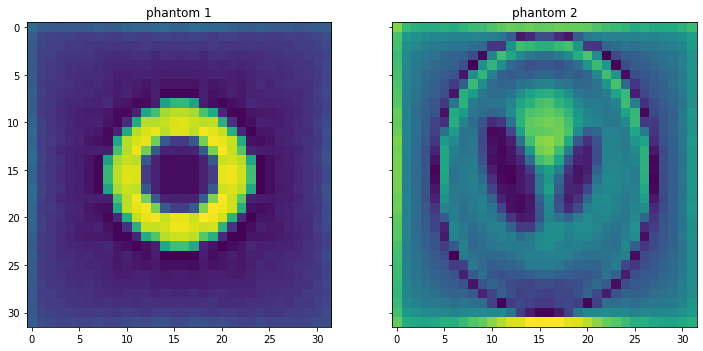

In [32]:
phantomsinc1 = sinc(projection1_32)
phantomsinc2 = sinc(projection2_32)

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
axs[0].imshow(phantomsinc1)
axs[0].set_title('phantom 1')
axs[1].imshow(phantomsinc2)
axs[1].set_title('phantom 2')
plt.show()

Разницу я вижу.

Появились артефакты по краям картинки. По фону этого изображения видно, что оно более гладкое, в задании 3.2 фон неоднородный. Видимо это как раз действие этого фильтра.

### 5. Ускорение FBP

In [54]:
ntheta = 512
nshift = 256

shifts = np.linspace(-1, 1, nshift)
theta = np.linspace(0, 2*np.pi, ntheta, endpoint = False)

projections_exterior_data = np.reshape((np.fromfile(filename, dtype=np.float)), (ntheta, nshift))

fourieprojection = []

for i in range(ntheta):
  fourieprojection.append(fftshift(fft(ifftshift(projections_exterior_data[i]))))

for i in range(nshift):
  for j in range(ntheta):
    fourieprojection[j][i] = fourieprojection[j][i] * np.abs(shifts[i])

fourieprojection = np.reshape(fourieprojection, (ntheta*nshift, 1))


setting image dimension Nd... (1024, 1024)
setting spectrum dimension Kd... (2048, 2048)
setting interpolation size Jd... (6, 6)


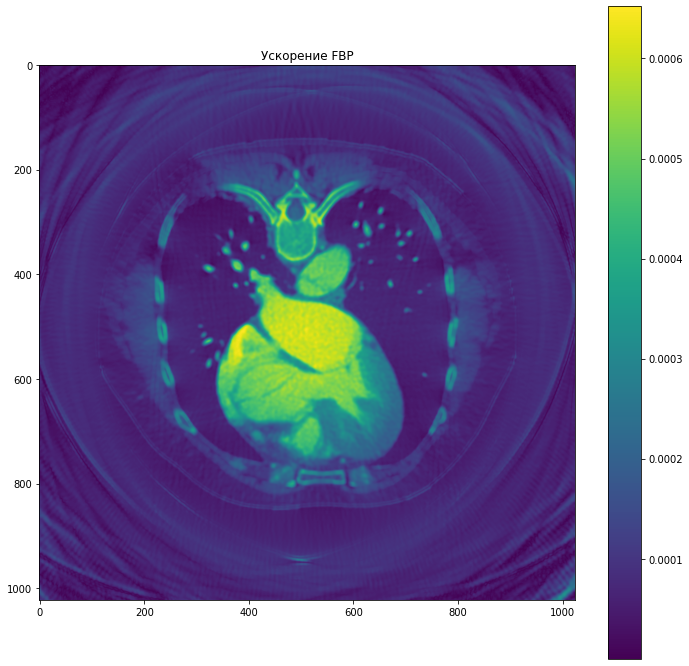

In [55]:
!pip install pynufft
from pynufft import NUFFT

om = np.zeros((ntheta*nshift, 2))

for j in range(nshift):
  for i in range(ntheta):
    om[i*nshift + j][0] = shifts[j] * np.sin(theta[i])
    om[i*nshift + j][1] = shifts[j] * np.cos(theta[i])


NufftObj = NUFFT()

Nd = (1024, 1024)  # image size
print('setting image dimension Nd...', Nd)
Kd = (2048, 2048)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

NufftObj.plan(om, Nd, Kd, Jd)

image = NufftObj.adjoint(fourieprojection)

fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(np.abs(image))
axs.set_title('Ускорение FBP')
fig.colorbar(im, ax=axs)
plt.show()